In [1]:
# Bilbiotecas para auxílio na programação matemática
import math, sys 
import numpy as np
import sympy as sp
import cmath
import time
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy import sparse # Produção das diagonais das matrizes
from scipy.sparse import diags 
from scipy.linalg import expm

# Plotagem 2D e 3D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm


from os import path # Suficiente para manipulação de arquivos
    
# Para solução exata
from scipy.special import hermite
from math import factorial

%matplotlib inline
count = 0

# Para otimização dos sistemas
from scipy import optimize
from random import randint, uniform
from scipy.linalg import sqrtm

In [2]:
# Manipulação das matrizes, soma e subtração

def somar(A, B):
    C = []
    num_linhas_a = len(A)
    num_colunas_a = len(A[0])
    
    for i in range (num_linhas_a):
        linha = [0]*num_colunas_a
        C.append(linha)
        for j in range(num_colunas_a):
            C[i][j] = A[i][j] + B[i][j]

    return C

def sub(A, B):
    C = []
    num_linhas_a = len(A)
    num_colunas_a = len(A[0])
    
    for i in range (num_linhas_a):
        linha = [0]*num_colunas_a
        C.append(linha)
        for j in range(num_linhas_a):
            C[i][j] = A[i][j] - B[i][j]

    return C

In [3]:
## CONSTANTES PARA O CONTROLADOR

# Considerações: constante de Planck verdadeira: 1, massa: 1

TEMPO_ANALISE = 10 
QUANTIDADE_PONTOS_AMOSTRAGEM = 100
PASSO = TEMPO_ANALISE/QUANTIDADE_PONTOS_AMOSTRAGEM

MIN_HORIZONTE = 3 # Horizonte mínimo da análise
MAX_HORIZONTE = 30 # Horizonte máximo da análise

# Com horizonte em 10, a avaliação dura em torno de 80 minutos 

DESEJADO = [[0.00],[1.00]] # [[c1];[c2]] = [[0.707],[-0.707]]
RHO_DESEJADO = np.matmul(DESEJADO, np.transpose(DESEJADO))
print(RHO_DESEJADO)

# Determinação dos valores de início e fim da análise
num = PASSO
contador = 0
while num < 1:
    num *= 10
    contador += 1

EXPOENTE = contador
INICIO_ANALISE = 0*10**(-EXPOENTE) # Tempo inicial da analise em um horizonte
FINAL_ANALISE = (1*10**(-EXPOENTE))+PASSO # Tempo final da analise em um horizonte

[[0. 0.]
 [0. 1.]]


In [4]:
## CONSTANTES PARA O ALGORITMO GENÉTICO

ELITISMO = True
PORCENTAGEM_ELITISMO = 0.20

TAMANHO_POP = 50
TAXA_MUTACAO = 0.10
TAXA_CRUZAMENTO = 0.70
GERACOES = 100

# Valores mínimos e máximos para gerar uma população
MIN = -5
MAX = 5

In [5]:
def dpsi_dt(t, ro, H): # A derivada da ro em relação ao tempo não tem dependência temporal
    A = np.zeros((2,2), dtype=np.complex128)
    M = [[0, -ro[0][1]], [-ro[1][0], 0]]
    A = (np.dot(H,ro))-(np.dot(ro, H)) # [H,p]
    #return -1j*A+np.dot(M, 0.15)
    return -1j*A

# Runge-Kutta de quarta ordem

def runge_kutta(onda, fator_runge_kutta, hamiltoniano, tempo_inicial = 0):

    k1 = dpsi_dt(tempo_inicial, onda, hamiltoniano)
    k2 = dpsi_dt(tempo_inicial + 0.5 * fator_runge_kutta, somar(onda, np.dot((0.5*fator_runge_kutta), k1)), hamiltoniano)
    k3 = dpsi_dt(tempo_inicial + 0.5 * fator_runge_kutta, somar(onda, np.dot((0.5*fator_runge_kutta), k2)), hamiltoniano)
    k4 = dpsi_dt(tempo_inicial + fator_runge_kutta, somar(onda, np.dot(fator_runge_kutta, k3)), hamiltoniano)
    
    ## y(i+1) = y(i) + h/6*(k1+2*k2+2*k3+k4)
    
    A = somar(np.dot(2,k3), k4)
    B = somar(np.dot(2,k2), k1)
    C = somar(A, B)

    runge = somar(onda,np.dot((fator_runge_kutta / 6.0),(C)))
    
    return runge

In [6]:
def func_objetivo(vetor_controles, tempo_atual, rho_desejado, 
                  rho_atual, H, horizonte, fator_runge_kutta):
    
    fo = 0
    pos = 0
    
    tempo_inicial = INICIO_ANALISE
    tempo_final = FINAL_ANALISE
    
    controles = np.zeros((2,2), dtype=np.complex128)
    #controles = [[0, complex(vetor_controles[0], vetor_controles[1])], [complex(vetor_controles[0], -vetor_controles[1]), 0]]
    controles = [[0, vetor_controles[0]], [vetor_controles[0], 0]]
    
    matriz_inicial = rho_atual

    matriz_desejada = np.zeros((2,2),dtype=np.complex128)
    hamiltoniano = H

    H = [[np.exp(1j*np.pi*tempo_atual/2),0],[0,np.exp(3j*np.pi*tempo_atual/2)]]
    U = H
    U = np.asmatrix(U)
    U_dagger = U.getH()
    teste = np.dot(np.dot(U,rho_desejado),U_dagger)
    matriz_desejada = np.squeeze(np.asarray(teste))

    matriz_teste = sub(matriz_inicial, matriz_desejada)
    
    teste = []
    for m in range(0, 2):
        teste.append(abs(matriz_teste[0][m])+abs(matriz_teste[1][m]))
    
    fo += max(teste)

    runge = runge_kutta(matriz_inicial, fator_runge_kutta, 
                        somar(hamiltoniano, controles), tempo_inicial = tempo_inicial)

    matriz_inicial = runge

    tempo_inicial = round(tempo_inicial+PASSO, EXPOENTE)
    tempo_final = round(tempo_final+PASSO, EXPOENTE)
    tempo = round(tempo_atual+PASSO, EXPOENTE)
    pos += 2

    while horizonte > 1:
        
        H = [[np.exp(1j*np.pi*tempo/2),0],[0,np.exp(3j*np.pi*tempo/2)]]
        U = H
        U = np.asmatrix(U)
        U_dagger = U.getH()
        teste = np.dot(np.dot(U,rho_desejado),U_dagger)
        matriz_desejada = np.squeeze(np.asarray(teste))

        matriz_teste = sub(matriz_inicial, matriz_desejada)
        
        teste = []
        for m in range(0, 2):
            teste.append(abs(matriz_teste[0][m])+abs(matriz_teste[1][m]))
        
        fo += max(teste)
        
        #controles = [[0, complex(vetor_controles[pos], vetor_controles[pos+1])], [complex(vetor_controles[pos], -vetor_controles[pos+1]), 0]]
        controles = [[0, vetor_controles[0]], [vetor_controles[0], 0]]

        runge = runge_kutta(matriz_inicial, fator_runge_kutta, 
                        somar(hamiltoniano, controles), tempo_inicial = tempo_inicial)

        matriz_inicial = runge

        tempo_inicial = round(tempo_inicial+PASSO, EXPOENTE)
        tempo_final = round(tempo_final+PASSO, EXPOENTE)
        tempo = round(tempo_atual+PASSO, EXPOENTE)
        horizonte -= 1

    return fo

In [7]:
def main(horizonte, rho_inicial):
    
    u = [] # Controles 
    for i in range(0, horizonte):
        u.append(uniform(-0.75,0.75))

    evolucao = np.zeros((4,QUANTIDADE_PONTOS_AMOSTRAGEM), dtype=np.complex128)
        
    # O que será retornado por essa função
    
    vetor_controles = np.zeros((2, QUANTIDADE_PONTOS_AMOSTRAGEM), dtype=np.complex128) # Valores de controle
    
    H = np.zeros((2,2), dtype=np.complex128)
    H = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    tempo = 0
    pos = 0
    while tempo < TEMPO_ANALISE:

        evolucao[0][pos] = rho_inicial[0][0]
        evolucao[1][pos] = rho_inicial[1][0]
        evolucao[2][pos] = rho_inicial[0][1]
        evolucao[3][pos] = rho_inicial[1][1]

        bounds = [(-0.75,0.75)]
    
        resultado = optimize.minimize(func_objetivo, u, args=(tempo, RHO_DESEJADO, rho_inicial, H, horizonte, PASSO), bounds=bounds, method='L-BFGS-B')
        
        controle = np.zeros((2,2), dtype=np.complex128)

        vetor_controles[0][pos] = resultado.x[0]
        vetor_controles[1][pos] = resultado.x[1]

        print(f"Controles: {complex(resultado.x[0],resultado.x[1])} e {complex(resultado.x[0],-resultado.x[1])}\n-------------------------")
        
        controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
        #controle = [[0, complex(resultado.x[0],resultado.x[1])],[complex(resultado.x[0],-resultado.x[1]), 0]]
        H = somar(H, controle)
    
        ## Adaptação da onda ao controle
        
        rho_avancado = runge_kutta(rho_inicial, PASSO, H, tempo_inicial = INICIO_ANALISE)
        rho_inicial = rho_avancado
        
        # Reset
        H = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
        u = [] # Controles 
        for i in range(0, horizonte):
            u.append(resultado.x[0])
            u.append(resultado.x[1])
        
        pos += 1
        tempo = round(tempo+PASSO, EXPOENTE)
        
    print(f'O rho alcançado foi: {rho_inicial}')
    print(f'A fidelidade do experimento é de: {(np.trace(np.sqrt(np.sqrt(rho_inicial)*RHO_DESEJADO*np.sqrt(rho_inicial))))}')
    print(f'A fidelidade do experimento é de: {(np.trace(sqrtm(sqrtm(rho_inicial) @ RHO_DESEJADO @ sqrtm(rho_inicial))))**2}')
    return evolucao, vetor_controles
    

In [8]:
# Plotagem 2D e 3D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

def plot_componentes(valores_onda,  evolucao_d, componente):
    
    ts1 = np.linspace(0, TEMPO_ANALISE, QUANTIDADE_PONTOS_AMOSTRAGEM)
    ts2 = np.linspace(0, TEMPO_ANALISE, QUANTIDADE_PONTOS_AMOSTRAGEM)
    
    real_primeiro = [elemento.real for elemento in valores_onda[componente-1]]
    imaginario_primeiro = [elemento.imag for elemento in valores_onda[componente-1]]
    
    real_segundo = [elemento.real for elemento in evolucao_d[componente-1]]
    imaginario_segundo = [elemento.imag for elemento in evolucao_d[componente-1]]
    
    # Plotagem
    plt.subplot(2,1,1)

    plt.ylabel('Pesos') 
    plt.xlabel('Tempo') 
    plt.title(f"{componente}ª coluna da matriz de densidade -> real")
    plt.plot(ts1, real_primeiro, color='r', marker='*', linewidth=1, markersize=1, label="primeiro")
    plt.plot(ts2, real_segundo, color='b', marker='o',  linewidth=1, markersize=1, label="segundo")
    plt.legend(loc='upper right')

    plt.axis([0,TEMPO_ANALISE,-1,1])
    
    plt.subplot(2,1,2)

    plt.ylabel('Imaginário') 
    plt.xlabel('Tempo') 
    plt.title(f"{componente}ª coluna da matriz de densidade -> imaginário")
    plt.plot(ts1, imaginario_primeiro, color='r', marker='*', linewidth=1, markersize=1, label="primeiro")
    plt.plot(ts2, imaginario_segundo, color='b', marker='o',  linewidth=1, markersize=1, label="segundo")
    plt.legend(loc='upper right')

    plt.axis([0,TEMPO_ANALISE,-1,1])

    plt.tight_layout()
    

In [9]:
PSI = np.ones((2,1), dtype=np.complex128)
PSI = [[1.00],[0.00]]
ro = np.matmul(PSI, np.transpose(PSI))
evolucao, vetor_controles = main(10, ro)

Controles: (-2.4577101964873397e-09-0.05496042356468733j) e (-2.4577101964873397e-09+0.05496042356468733j)
-------------------------
Controles: (-2.4577101964873397e-09-0.05496042356468733j) e (-2.4577101964873397e-09+0.05496042356468733j)
-------------------------
Controles: (-2.4577101964873397e-09-0.05496042356468733j) e (-2.4577101964873397e-09+0.05496042356468733j)
-------------------------
Controles: (-2.4577101964873397e-09-0.05496042356468733j) e (-2.4577101964873397e-09+0.05496042356468733j)
-------------------------
Controles: (-2.4577101964873397e-09-0.05496042356468733j) e (-2.4577101964873397e-09+0.05496042356468733j)
-------------------------
Controles: (-2.4577101964873397e-09-0.05496042356468733j) e (-2.4577101964873397e-09+0.05496042356468733j)
-------------------------
Controles: (-2.4577101964873397e-09-0.05496042356468733j) e (-2.4577101964873397e-09+0.05496042356468733j)
-------------------------
Controles: (-2.4577101964873397e-09-0.05496042356468733j) e (-2.45771

In [10]:
def acao_controle(valor):
    ts = np.linspace(0, TEMPO_ANALISE, QUANTIDADE_PONTOS_AMOSTRAGEM)

    plt.ylabel('Ação de controle')
    plt.xlabel('Tempo')
    plt.plot(ts, valor[0], color='k', marker='o', linewidth=1, markersize=1, label="Valor da ação de controle")
    plt.legend(loc="upper right")
    plt.title(f"Ação de controle")
    plt.grid()
    plt.show()

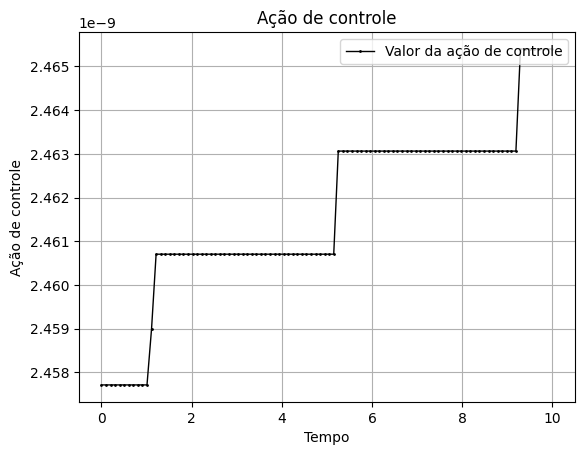

In [11]:
acao_controle(np.abs(vetor_controles))

In [12]:
def densidade(rho, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel('Valores da matriz de densidade') 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, abs(rho[0]), color='g', marker='o', linewidth=1, markersize=5, label=r"$\rho_{00}$")
    ax.plot(ts, abs(rho[1]), color='b', marker='v', linewidth=1, markersize=5, label=r"$\rho_{01}$")
    ax.plot(ts, abs(rho[2]), color='r', marker='+', linewidth=1, markersize=5, label=r"$\rho_{10}$")
    ax.plot(ts, abs(rho[3]), color='y', marker='*', linewidth=1, markersize=5, label=r"$\rho_{11}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Evolução da matriz de densidade $\gamma = {lbda}$")
    
    plt.show()

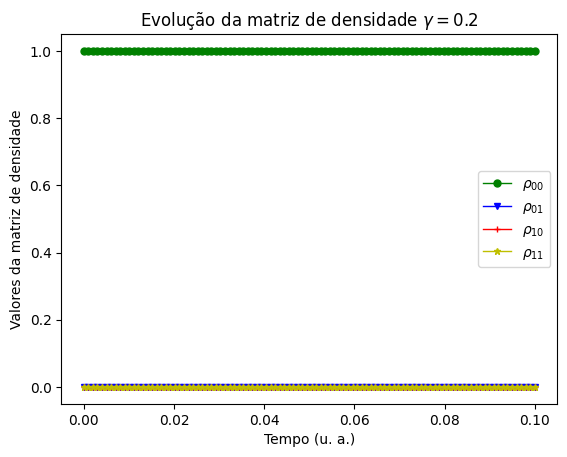

In [13]:
densidade(evolucao, 100, 0.20)